# JPEG Compression Defense Details on Object Detection 
This notebook provides a beginner friendly introduction to the JPEG compression defense and its quality parameter as part of Test & Evaluation of a the VisDrone dataset. We first use a PGD attack with a large perturbation and then apply a high quality parameter before comparing the output to the same defense with a lower value for quality. To this end, we plot both the compressed adversarial example as well as the detector's output. Understanding a defense's parameters effect on performance is a crucial step in T&E. 

❗**Defenses may alleviate attacks, but the underlying classifier can still be vulnerable**❗

__Intended Audience__: All T&E users 

__Requirements__: Basic Python and Torchvision / ML skills, object detection 

__Time Required__: Full run of the notebook: <3 minutes

__Order of completion__: 1-7, 4 and 5 in any order

### Contents
1. Imports and set-up
2. Load data and model
3. Initialize and run the attack
4. JPEG compression parameters - high quality
5. JPEG compression parameters - low quality
6. Conclusion and 7. Next steps

### Take-aways 
- how to apply a PGD attack on object detection
- how the quality parameter in JPEG compression affects the input image
- how the quality parameter affects model performance under attack


## 1. Imports and set-up

We import all necessary libraries for this tutorial. In this order, we first import general libraries such as numpy, then load relevant methods from ART. We then load the corresponding HEART functionality and specific torch functions to support the model. Lastly, we use a command to plot within the notebook.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2
import torchvision
from typing import Tuple, Dict, Any
from heart_library.estimators.object_detection import JaticPyTorchObjectDetector
from datasets import load_dataset
from art.attacks.evasion import ProjectedGradientDescent
from datasets import Dataset
from art.defences.preprocessor import JpegCompression
from heart_library.metrics import AccuracyPerturbationMetric
from heart_library.attacks.attack import JaticAttack
from art.attacks.evasion import ProjectedGradientDescentPyTorch
from functools import partial
from torchvision.transforms import transforms
from io import BytesIO

%matplotlib inline

In [2]:
# given a confidence threshold, determine which of the mdoel's predictions are relevent
def extract_predictions(predictions_, conf_thresh):
    # Get the predicted class
    predictions_class = [visdrone_labels[i] for i in list(predictions_.labels)]
    #  print("\npredicted classes:", predictions_class)
    if len(predictions_class) < 1:
        return [], [], []
    # Get the predicted bounding boxes
    predictions_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(predictions_.boxes)]

    # Get the predicted prediction score
    predictions_score = list(predictions_.scores)
    # print("predicted score:", predictions_score)

    # Get a list of index with score greater than threshold
    threshold = conf_thresh
    predictions_t = [predictions_score.index(x) for x in predictions_score if x > threshold]
    if len(predictions_t) > 0:
        predictions_t = predictions_t  # [-1] #indices where score over threshold
    else:
        # no predictions esxceeding threshold
        return [], [], []
    # predictions in score order
    predictions_boxes = [predictions_boxes[i] for i in predictions_t]
    predictions_class = [predictions_class[i] for i in predictions_t]
    predictions_scores = [predictions_score[i] for i in predictions_t]
    return predictions_class, predictions_boxes, predictions_scores

#plot an image with objects with the predicted bounding boxes on top
def plot_image_with_boxes(img, boxes, pred_cls, title):
    img = (img*255).astype(np.uint8)
    text_size = 1.5
    text_th = 2
    rect_th = 2

    for i in range(len(boxes)):
        cv2.rectangle(img, (int(boxes[i][0][0]), int(boxes[i][0][1])), (int(boxes[i][1][0]), int(boxes[i][1][1])),
                      color=(0, 255, 0), thickness=rect_th)
        # Write the prediction class
        cv2.putText(img, pred_cls[i], (int(boxes[i][0][0]), int(boxes[i][0][1])), cv2.FONT_HERSHEY_SIMPLEX, text_size,
                    (0, 255, 0), thickness=text_th)

    plt.figure()
    plt.axis("off")
    plt.title(title)
    plt.imshow(img, interpolation="nearest")
    # plt.show()
    
#wrapper for image datasets 
class ImageDataset:
    
    metadata = {"id": "example"}
    
    def __init__(self, images, groundtruth, threshold=0.8):
        self.images = images
        self.groundtruth = groundtruth
        self.threshold = threshold
        
    def __len__(self)->int:
        return len(self.images)
    
    def __getitem__(self, ind: int) -> Tuple[np.ndarray, np.ndarray, Dict[str, Any]]:
        image = np.asarray(self.images[ind]["image"]).astype(np.float32)
        
        filtered_detection = self.groundtruth[ind]
        filtered_detection.boxes = filtered_detection.boxes[filtered_detection.scores>self.threshold]
        filtered_detection.labels = filtered_detection.labels[filtered_detection.scores>self.threshold]
        filtered_detection.scores = filtered_detection.scores[filtered_detection.scores>self.threshold]
        
        return (image, filtered_detection, None)

# specific dataset class to craft a targeted adversarial patch 
class TargetedImageDataset:
    
    metadata = {"id": "example"}
    
    def __init__(self, images, groundtruth, target_label, threshold=0.5):
        self.images = images
        self.groundtruth = groundtruth
        self.target_label = target_label
        self.threshold = threshold
        
    def __len__(self)->int:
        return len(self.data)
    
    def __getitem__(self, ind: int) -> Tuple[np.ndarray, np.ndarray, Dict[str, Any]]:
        image = self.images.__getitem__(ind)["image"]
        targeted_detection = self.groundtruth[ind]
        targeted_detection.boxes = targeted_detection.boxes[targeted_detection.scores>self.threshold]
        targeted_detection.scores = np.asarray([1.0]*len(targeted_detection.boxes))
        targeted_detection.labels = [self.target_label]*len(targeted_detection.boxes)
        return (image, targeted_detection, {})

## 2. Load the dataset and model
We load the data, importing only a small part (5 samples) to save compute for this small demonstration. We then define the model and wrap it as JATIC pytorch classifier and test it's output on our samples.

In [3]:
visdrone_labels = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

NUM_SAMPLES = 5

data = load_dataset("Voxel51/VisDrone2019-DET", split="train", streaming=True)
sample_data = data.take(NUM_SAMPLES)

def gen_from_iterable_dataset(iterable_ds):
    yield from iterable_ds

sample_data = Dataset.from_generator(partial(gen_from_iterable_dataset, sample_data), features=sample_data.features)

IMAGE_H, IMAGE_W = 800, 800

preprocess = transforms.Compose([
    transforms.Resize((IMAGE_H, IMAGE_W)),
    transforms.ToTensor()
])

sample_data = sample_data.map(lambda x: {"image": preprocess(x["image"]), "label": None})

Resolving data files:   0%|          | 0/8632 [00:00<?, ?it/s]

Using cache found in /Users/kgr/.cache/torch/hub/facebookresearch_detr_main


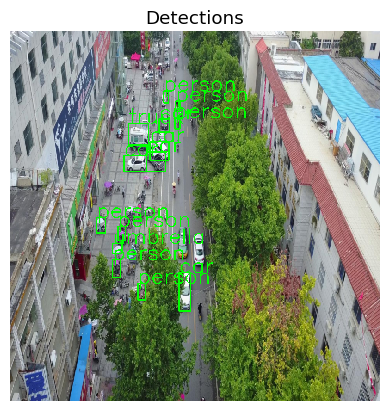

In [4]:
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225] 
preprocessing=(MEAN, STD)

detector = JaticPyTorchObjectDetector(model_type="detr_resnet50",
                                      device_type='cpu',
                                    input_shape=(3, 800, 800),
                                    clip_values=(0, 1), 
                                    attack_losses=("loss_ce",), 
                                    preprocessing=(MEAN, STD))

detections = detector(sample_data)

# plot the input images with the corresponding classification output
for i in range(1): # to plot all: range(len(sample_data))):
    preds_orig = extract_predictions(detections[i], 0.8)
    img = np.asarray(sample_data.__getitem__(i)['image']).transpose(1,2,0)
    plot_image_with_boxes(img=img.copy(), boxes=preds_orig[1], pred_cls=preds_orig[0], title="Detections")

## 3. Initialize and run the attack

We initialize the attack with a very strong maximal allowed perturbation (eps=0.05) to create a visible perturbation to analyze the effect of the detector better. 

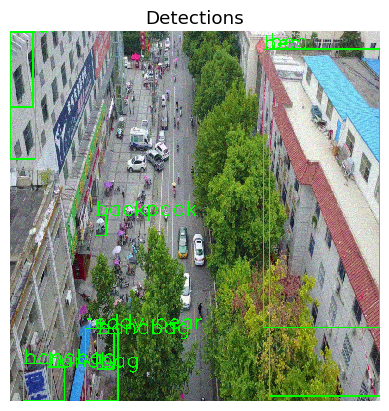

In [5]:
attack = JaticAttack(ProjectedGradientDescent(detector, max_iter=15, eps_step=0.01, eps=0.1, targeted=False, verbose=False), norm=2)

x_advPGD, y, metadata = attack(data=sample_data)
detections = detector(np.stack(x_advPGD))

#plot images and predictions for two images
for i in range(1): #for all, write range(len(x_adv)):
    preds_orig = extract_predictions(detections[i], 0.8)
    img = np.asarray(x_advPGD[i].transpose(1,2,0))
    plot_image_with_boxes(img=img.copy(), boxes=preds_orig[1], pred_cls=preds_orig[0], title="Detections")


The effect of the attack is evident, as the detector recognizes few objects which are not in the image (teddy bear, backpack).

## 4. JPEG compression parameters - high quality

We now investigate the effect of the defense on this adversarial example, starting with a very high image quality. To assess the effect of the defense, we first plot the image resulting from image compression and then plot the output of the object detector on that image (however with the adversarial example in the background).

Using cache found in /Users/kgr/.cache/torch/hub/facebookresearch_detr_main


(800, 800, 3) 4
(1, 800, 800, 3)


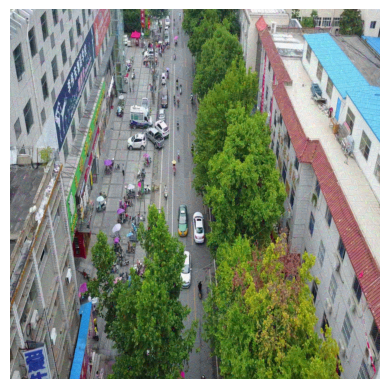

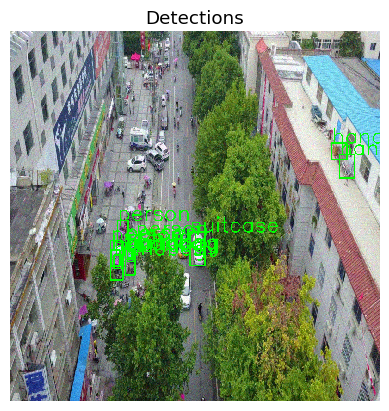

In [6]:
from art.defences.preprocessor import JpegCompression
preprocessing_defense = JpegCompression(clip_values=(0,1),
                                        channels_first=True,
                                        apply_predict=True,
                                        quality=75
                                        )

detector_defended = JaticPyTorchObjectDetector(model_type="detr_resnet50",
                                                device_type='cpu',
                                                input_shape=(3, 800, 800),
                                                clip_values=(0, 1), 
                                                attack_losses=( "loss_ce",
                                                    "loss_bbox",
                                                    "loss_giou",), 
                                                preprocessing=(MEAN, STD),
                                                preprocessing_defences=[preprocessing_defense])

'''
View detections on adversarial images
'''
img = np.asarray(x_advPGD[0]).transpose(1,2,0)

print(np.shape(img),img.reshape(1,800,800,3).ndim)

detections = detector(sample_data)
preds_orig = extract_predictions(detections[i], 0.8)
compressed = preprocessing_defense(img.copy().reshape(1,800,800,3))[0]

print(np.shape(compressed))
plt.imshow(compressed.reshape(800,800,3))
plt.axis("off")
plt.show()
#plt.imshow(img.reshape(800,800,3))
#plt.show()
#plot_image_with_boxes(img=uncompressed,
#                      boxes=preds_orig[1], pred_cls=preds_orig[0], title="Detections")
adv_detections = detector_defended(x_advPGD)
for i in range(1): #len(adv_detections)): 
    preds_orig = extract_predictions(adv_detections[i], 0.8)
    plot_image_with_boxes(img=x_advPGD[i].transpose(1,2,0).copy(),
                          boxes=preds_orig[1], pred_cls=preds_orig[0], title="Detections")

In the upper image, we see slight changes in the image (if a tall), and in the bottom we see that while more objects are detected, that only some of them (person) are actually in the image. While the preprocessing thus alleviates the attack, it cannot recover full performance.

## 5. JPEG compression low quality
We thus repeat the previous experiment, using  a much lower value for quality, 15.

Using cache found in /Users/kgr/.cache/torch/hub/facebookresearch_detr_main


(800, 800, 3) 4
(1, 800, 800, 3)


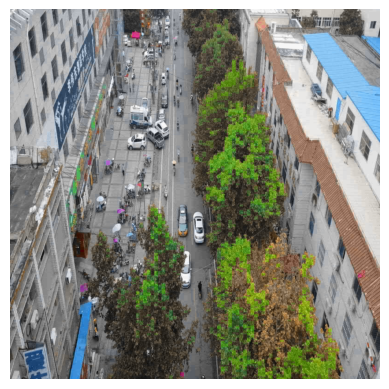

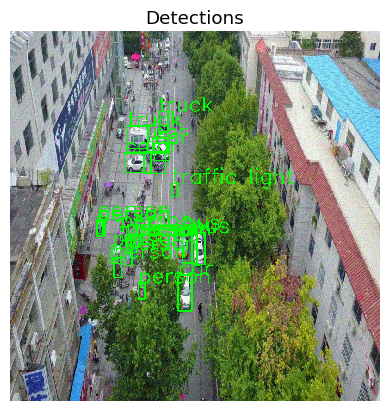

In [8]:
from art.defences.preprocessor import JpegCompression
preprocessing_defense = JpegCompression(clip_values=(0,1),
                                        channels_first=True,
                                        apply_predict=True,
                                        quality=15
                                        )

detector_defended = JaticPyTorchObjectDetector(model_type="detr_resnet50",
                                                device_type='cpu',
                                                input_shape=(3, 800, 800),
                                                clip_values=(0, 1), 
                                                attack_losses=( "loss_ce",
                                                    "loss_bbox",
                                                    "loss_giou",), 
                                                preprocessing=(MEAN, STD),
                                                preprocessing_defences=[preprocessing_defense])

'''
View detections on adversarial images
'''
img = np.asarray(sample_data.__getitem__(0)['image']).transpose(1,2,0)

print(np.shape(img),img.reshape(1,800,800,3).ndim)

detections = detector(sample_data)
preds_orig = extract_predictions(detections[i], 0.8)
compressed = preprocessing_defense(img.copy().reshape(1,800,800,3))[0]

print(np.shape(compressed))
plt.imshow(compressed.reshape(800,800,3))
plt.axis("off")
plt.show()
#plt.imshow(img.reshape(800,800,3))
#plt.show()
#plot_image_with_boxes(img=uncompressed,
#                      boxes=preds_orig[1], pred_cls=preds_orig[0], title="Detections")
adv_detections = detector_defended(x_advPGD)
for i in range(1): #len(adv_detections)): 
    preds_orig = extract_predictions(adv_detections[i], 0.8)
    plot_image_with_boxes(img=x_advPGD[i].transpose(1,2,0).copy(),
                          boxes=preds_orig[1], pred_cls=preds_orig[0], title="Detections")

In the upper image, we now see strong changes in colors, for example in the red roof or the trees. In the bottom image depicting the detected objects, we see that much of the performance is indeed recovered.

## 7. Conclusion
In JPEG compression, a lower quality reduces the details remaining in the image and thus remove stronger perturbations. However, this may be circumvented by even stronger attacks. Yet, the quality in this defense is an important parameter to be considered in T&E. 

## 8. Next steps
- Image classification how-to's